In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

data = pd.read_excel("WindPark VI.xlsx", index_col = 0, parse_dates = True)

# Multivariate Time Series Forecasting using Support Vector Regression

In [2]:
#a function to clean and prepare the data set
def clean_data(df_):
    
    df = df_.copy()
    
    all_cols = df.columns
    
    #creating a list for each category of variables
    active_power_avg = ['WTG 1-Active power avg [kW]', 'WTG 10-Active power avg [kW]', 
       'WTG 11-Active power avg [kW]', 'WTG 2-Active power avg [kW]', 
       'WTG 3-Active power avg [kW]', 'WTG 4-Active power avg [kW]',
       'WTG 5-Active power avg [kW]', 'WTG 6-Active power avg [kW]',
       'WTG 7-Active power avg [kW]', 'WTG 8-Active power avg [kW]',
       'WTG 9-Active power avg [kW]']

    wind_speed_avg = ['WTG 1-Wind speed avg [m/s]', 'WTG 10-Wind speed avg [m/s]', 
       'WTG 11-Wind speed avg [m/s]', 'WTG 2-Wind speed avg [m/s]', 
       'WTG 3-Wind speed avg [m/s]', 'WTG 4-Wind speed avg [m/s]',
       'WTG 5-Wind speed avg [m/s]', 'WTG 6-Wind speed avg [m/s]',
       'WTG 7-Wind speed avg [m/s]', 'WTG 8-Wind speed avg [m/s]',
       'WTG 9-Wind speed avg [m/s]']

    wind_direction_avg = ['WTG 1-Wind direction avg [°]', 'WTG 10-Wind direction avg [°]', 
       'WTG 11-Wind direction avg [°]', 'WTG 2-Wind direction avg [°]', 
       'WTG 3-Wind direction avg [°]', 'WTG 4-Wind direction avg [°]',
       'WTG 5-Wind direction avg [°]', 'WTG 6-Wind direction avg [°]',
       'WTG 7-Wind direction avg [°]', 'WTG 8-Wind direction avg [°]',
       'WTG 9-Wind direction avg [°]']

    ambient_temperature_avg = ['WTG 1-Ambient temperature avg [°C]', 'WTG 10-Ambient temperature avg [°C]', 
       'WTG 11-Ambient temperature avg [°C]', 'WTG 2-Ambient temperature avg [°C]', 
       'WTG 3-Ambient temperature avg [°C]', 'WTG 4-Ambient temperature avg [°C]',
       'WTG 5-Ambient temperature avg [°C]', 'WTG 6-Ambient temperature avg [°C]',
       'WTG 7-Ambient temperature avg [°C]', 'WTG 8-Ambient temperature avg [°C]',
       'WTG 9-Ambient temperature avg [°C]']
    
    #using the interpolate function to remove null values
    df = df.interpolate()
    
    #setting boundaries for the values of each category of variables, with the clip function
    df[active_power_avg] = df[active_power_avg].clip(0, 850)
    df[wind_speed_avg] = df[wind_speed_avg].clip(0, 30)
    df[wind_direction_avg] = df[wind_direction_avg].clip(0, 360)
    df[ambient_temperature_avg] = df[ambient_temperature_avg].clip(-10, 40)
    
    #creating new columns with the sum or average, depending on the category of variables
    df["Total Active power avg [kW]"] = df[active_power_avg].sum(axis = 1)
    df["Wind speed avg [m/s]"] = df[wind_speed_avg].mean(axis = 1)
    df["Ambient temperature avg [°C]"] = df[ambient_temperature_avg].mean(axis = 1)
    df["Wind direction avg [°]"] = df[wind_direction_avg].mean(axis = 1)
    
    #dropping the original columns
    df.drop(all_cols, axis = 1, inplace = True)
    
    #setting an hourly frequency to the time series
    df = df.resample('H').mean()
    
    return df

In [3]:
data = clean_data(data)
data.head()

,Total Active power avg [kW],Wind speed avg [m/s],Ambient temperature avg [°C],Wind direction avg [°]
TimeStamp,,,,
2016-01-01 00:00:00,1372.666667,5.936364,-4.060606,32.151515
2016-01-01 01:00:00,664.116667,4.743939,-4.045455,26.448485
2016-01-01 02:00:00,13.583333,2.871212,-3.757576,67.734848
2016-01-01 03:00:00,176.716667,3.675758,-3.939394,60.374242
2016-01-01 04:00:00,64.116667,3.280303,-3.863636,69.712121


First of all, we clean the data set, using the `clean_data()` function, which is based on what we did on the Exploratory Data Analysis part of the project.

In [4]:
def time_lags(df_, steps):
    
    df = df_.copy()
    cols = df.columns
        
    for col in cols:
        for i in range(1, steps + 1):
            df[col + f" (t-{str(i)})"] = df[col].shift(i)
            
    df.dropna(inplace = True)        
            
    return df

Supervised learning algorithms can't be used in time series forecasting problems, without modifying the data somehow. the `time_lags()` function adds a number of time lag columns on the data set. Those time lag values will be the features of the supervised learning algorithm. This is known as the sliding window method.

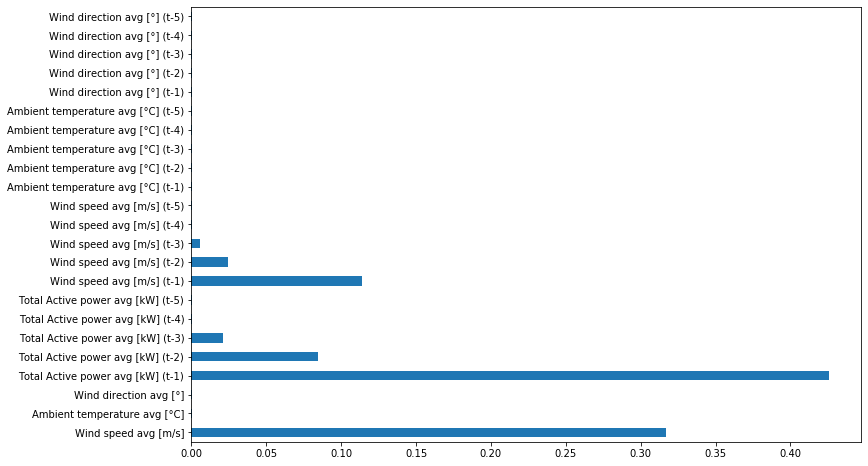

In [5]:
from sklearn.ensemble import ExtraTreesRegressor

data_lags = time_lags(data, 5)

x = data_lags.iloc[: , 1:]
y = data_lags.iloc[: , 0]

model = ExtraTreesRegressor(n_estimators = 100, n_jobs=-1)
model.fit(x, y)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
plt.figure(figsize=(12,8))
feat_importances.plot(kind='barh')

We fitted an `ExtraTreeRegressor()` model to our data, to understand which features are the most important. As we expected, based on the exploratory data analysis, wind speed is the most important feature. On the other hand, wind direction and ambient temperature don't contribute any significant information, and will not be included in the forecasting model. We can also see that the importance of the time lags decreases, for every step taken back in time.

In [104]:
lags = 5
cols = ["Total Active power avg [kW]", "Wind speed avg [m/s]"]

cols_arrange = ['Total Active power avg [kW]', 'Total Active power avg [kW] (t-1)',
       'Total Active power avg [kW] (t-2)', 'Total Active power avg [kW] (t-3)',
       'Total Active power avg [kW] (t-4)', 'Total Active power avg [kW] (t-5)',
       'Wind speed avg [m/s]', 'Wind speed avg [m/s] (t-1)',
       'Wind speed avg [m/s] (t-2)', 'Wind speed avg [m/s] (t-3)',
       'Wind speed avg [m/s] (t-4)', 'Wind speed avg [m/s] (t-5)']

#creating a univariate time series forecasting model for the wind speed variable
#to use its predictions as input for the multivariate time series forecasting model
data_wind = data.loc[:, ["Wind speed avg [m/s]"]]
data_wind = time_lags(data_wind, lags)
train_wind, test_wind = data_wind["2016":"2017"], data_wind["2018"]

train_x_wind = train_wind.iloc[:, 1:].values
train_y_wind = train_wind.iloc[:, 0].values

test_x_wind = test_wind.iloc[:, 1:].values
test_y_wind = test_wind.iloc[:, 0].values

scaler_x_wind = MinMaxScaler()
train_x_wind = scaler_x_wind.fit_transform(train_x_wind)
test_x_wind = scaler_x_wind.transform(test_x_wind)
scaler_y_wind = MinMaxScaler()
scaler_y_wind.fit(train_y_wind.reshape(-1,1))

model_wind = LinearSVR(C=100, max_iter=10000)
model_wind.fit(train_x_wind, train_y_wind)
    
#creating the multivariate time series forecasting model  
data_power = time_lags(data[cols], lags)
data_power = data_power[cols_arrange]
train_power, test_power = data_power["2016":"2017"], data_power["2018"]

train_x_power = train_power.iloc[:, 1:].values
train_y_power = train_power.iloc[:, 0].values
    
test_x_power = test_power.iloc[:, 1:].values
test_y_power = test_power.iloc[:, 0].values

scaler_x_power = MinMaxScaler()
train_x_power = scaler_x_power.fit_transform(train_x_power)
test_x_power = scaler_x_power.transform(test_x_power)
scaler_y_power = MinMaxScaler()
scaler_y_power.fit(train_y_power.reshape(-1,1))
  
model_power = LinearSVR(C=100, max_iter=10000)
model_power.fit(train_x_power, train_y_power)


LinearSVR(C=100, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0)

In [105]:
steps = 36
stop = len(test_x_power) - steps
rss = np.zeros(steps)
count = 0

for i in range(0, stop, steps):
    arr_predict = test_x_power[i]
    arr_power = arr_predict[0:5]
    arr_wind = arr_predict[6:]

    for j in range(0, steps):
        
        p_wind = model_wind.predict([arr_wind])
        p_wind = scaler_y_wind.transform([p_wind]).reshape(1,)
        
        concat = np.concatenate( (arr_power, p_wind, arr_wind) ) 
        p_power = model_power.predict([concat])

        arr_wind = np.delete(arr_wind, -1)
        arr_wind = np.insert(arr_wind, 0, p_wind)
        
        arr_power = np.delete(arr_power, -1)
        arr_power = np.insert(arr_power, 0, scaler_y_power.transform([p_power]))
        
        residual = test_y_power[j+i] - p_power
        rss[j] += pow(residual, 2)
        
    count += 1

rmse = np.sqrt(rss/count)

In [106]:
rmse

array([ 975.67666548, 1307.68764092, 1606.53702854, 1647.86700128,
       1886.62734653, 2237.80019717, 2387.76300229, 2238.89605966,
       2687.50116381, 2650.00237039, 2745.46462971, 2836.3736681 ,
       2710.45096292, 2777.49375576, 2713.13835738, 2576.36969889,
       2760.47831676, 2672.34520786, 2574.04266152, 2562.97945076,
       2714.84083139, 2968.15011669, 3045.34472744, 2871.06268827,
       2725.12340832, 2832.75241472, 2769.57500812, 2929.94242564,
       3054.2790392 , 3017.93734485, 3078.02977767, 3064.49457419,
       2857.54514787, 2798.24409232, 2730.90120957, 2539.30133737])

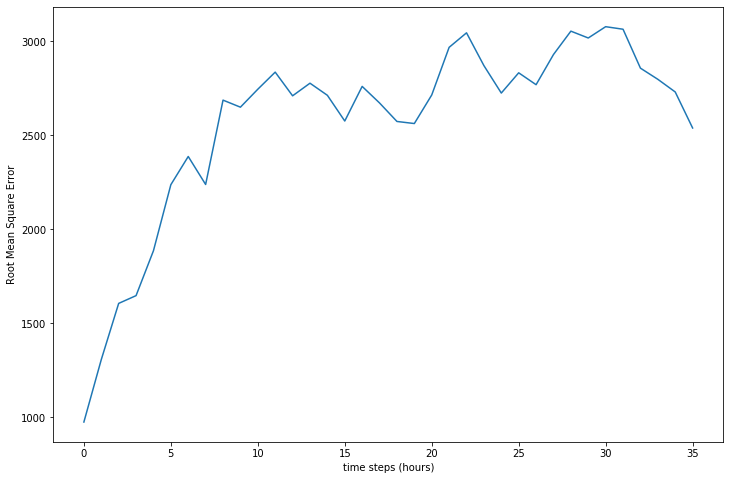

In [107]:
plt.figure(figsize=(12,8))
plt.ylabel("Root Mean Square Error")
plt.xlabel("time steps (hours)")
plt.plot(rmse)